In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
# Be able to import from src folder
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
print(PROJ_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))

import misc.notebookHelpers

%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.rcParams['figure.figsize'] = (10, 10)

/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation


In [8]:
data_path = os.path.join(PROJ_ROOT, 'data/processed/mitral_point_labeled/')

In [9]:
data_path

'/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/'

In [10]:
h5files = glob.glob(os.path.join(data_path, '*/*.h5'))
h5files

['/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p1/I53BBRO2.h5',
 '/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p1/I53BCBO6.h5',
 '/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p1/I53BCN8A.h5',
 '/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p1/I53BDC0E.h5',
 '/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p1/I53BDN8I.h5',
 '/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p1/I53BE4GM.h5',
 '/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p1/I53E6MSA.h5',
 '/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p1/I53E71CE.h5',


In [11]:
os.path.join(data_path, '*/*.h5')

'/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/*/*.h5'

Pick a random file and see if we can find a suitable point

In [34]:
file_idx = np.random.randint(0, len(h5files))
h5file = h5files[file_idx]

In [35]:
data = h5py.File(h5file)
list(data.keys())

['TVI', 'ecg', 'tissue']

In [36]:
video, fps = misc.notebookHelpers.video_and_fps_from_h5py(data, 'b-mode')
tvi_video = np.transpose(data['TVI/data'], [2, 1, 0])

Check that we can view the mitral points and that they make sense

In [37]:
misc.notebookHelpers.ultraSoundAnimation(video, fps=fps, points=data['tissue/mitral_points'])

Select the first frame, and search for points below the mitral points to track

In [38]:
frame = video[0, :, :]
mitral_points = data['tissue/mitral_points'][0, :, :]

In [39]:
list(data['tissue'].keys())

['data',
 'dirx',
 'diry',
 'ds_labels',
 'mitral_points',
 'origin',
 'pixelsize',
 'times']

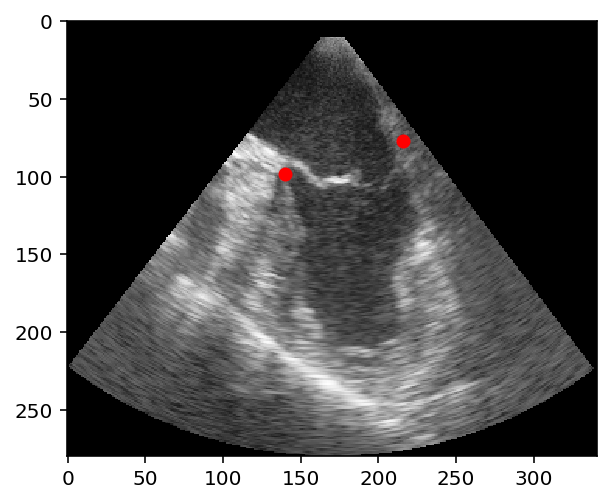

In [40]:
plt.imshow(frame, cmap='Greys_r')
plt.scatter(mitral_points[0, 1], mitral_points[0, 0], color='red')
plt.scatter(mitral_points[1, 1], mitral_points[1, 0], color='red')

In [41]:
data['tissue/pixelsize'][:]

array([0.0005, 0.0005])

In [42]:
def cm_to_pixel(num_cm, data_file, dim):
    pixel_size_cm = data_file['tissue/pixelsize'][dim] * 100
    return int(round(num_cm / pixel_size_cm))

In [43]:
search_box_left = np.array([[mitral_points[0, 0] + cm_to_pixel(2.5, data, 1), mitral_points[0, 0] + cm_to_pixel(4.5, data, 1)],
                            [mitral_points[0, 1] - cm_to_pixel(1, data, 0), mitral_points[0, 1] + cm_to_pixel(1, data, 0)]])

In [44]:
search_box_left

array([[148, 188],
       [120, 160]])

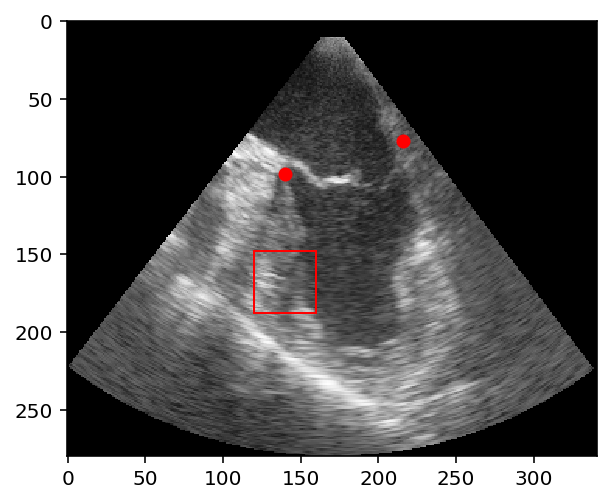

In [45]:
plt.imshow(frame, cmap='Greys_r')
plt.scatter(mitral_points[0, 1], mitral_points[0, 0], color='red')
plt.scatter(mitral_points[1, 1], mitral_points[1, 0], color='red')

rectangle = plt.Rectangle((search_box_left[1, 0], search_box_left[0, 0]), 
                           search_box_left[1, 1] - search_box_left[1, 0], 
                           search_box_left[0, 1] - search_box_left[0, 0], color='r', fill=False)
plt.gca().add_patch(rectangle)

In [46]:
left_search_region = frame[search_box_left[0, 0]:search_box_left[0, 1],
                           search_box_left[1, 0]:search_box_left[1, 1]]

In [47]:
mitral_points[0, 0]

98

In [48]:
flattened_index = np.argmax(left_search_region)
segment_point_left = np.unravel_index(flattened_index, left_search_region.shape)
segment_point_left = np.array([segment_point_left[0] + search_box_left[0, 0], segment_point_left[1] + search_box_left[1, 0]])
segment_point_left

array([168, 125])

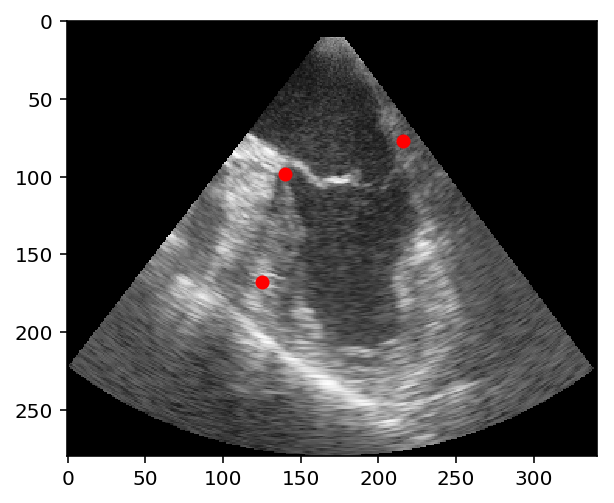

In [49]:
plt.imshow(frame, cmap='Greys_r')
plt.scatter(mitral_points[0, 1], mitral_points[0, 0], color='red')
plt.scatter(mitral_points[1, 1], mitral_points[1, 0], color='red')
plt.scatter(segment_point_left[1], segment_point_left[0], color='red')

In [50]:
search_box_right = np.array([[mitral_points[1, 0] + cm_to_pixel(2.5, data, 1), mitral_points[1, 0] + cm_to_pixel(4.5, data, 1)],
                            [mitral_points[1, 1] - cm_to_pixel(1, data, 0), mitral_points[1, 1] + cm_to_pixel(1, data, 0)]])

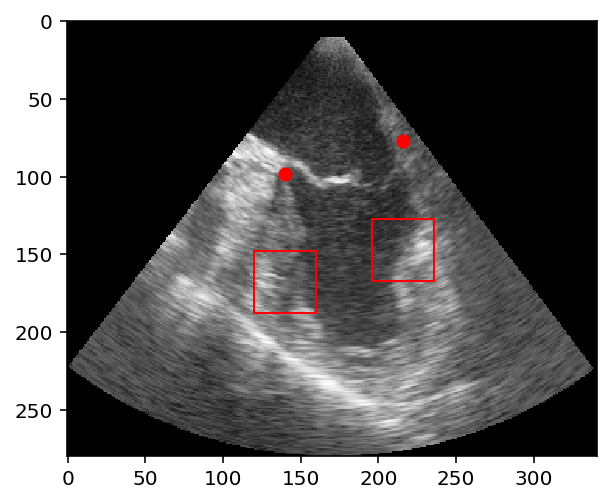

In [51]:
plt.imshow(frame, cmap='Greys_r')
plt.scatter(mitral_points[0, 1], mitral_points[0, 0], color='red')
plt.scatter(mitral_points[1, 1], mitral_points[1, 0], color='red')

rectangle = plt.Rectangle((search_box_left[1, 0], search_box_left[0, 0]), 
                           search_box_left[1, 1] - search_box_left[1, 0], 
                           search_box_left[0, 1] - search_box_left[0, 0], color='r', fill=False)
plt.gca().add_patch(rectangle)

rectangle = plt.Rectangle((search_box_right[1, 0], search_box_right[0, 0]), 
                           search_box_right[1, 1] - search_box_right[1, 0], 
                           search_box_right[0, 1] - search_box_right[0, 0], color='r', fill=False)
plt.gca().add_patch(rectangle)

In [52]:
right_search_region = frame[search_box_right[0, 0]:search_box_right[0, 1],
                           search_box_right[1, 0]:search_box_right[1, 1]]

In [53]:
flattened_index = np.argmax(right_search_region)
segment_point_right = np.unravel_index(flattened_index, right_search_region.shape)
segment_point_right = np.array([segment_point_right[0] + search_box_right[0, 0], segment_point_right[1] + search_box_right[1, 0]])
segment_point_right

array([143, 229])

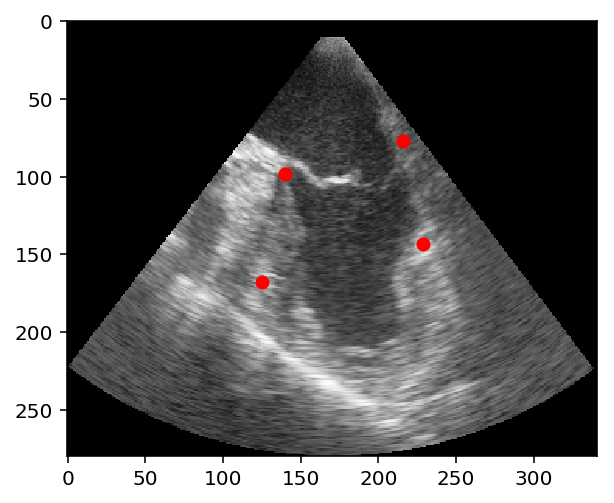

In [54]:
plt.imshow(frame, cmap='Greys_r')
plt.scatter(mitral_points[0, 1], mitral_points[0, 0], color='red')
plt.scatter(mitral_points[1, 1], mitral_points[1, 0], color='red')
plt.scatter(segment_point_left[1], segment_point_left[0], color='red')
plt.scatter(segment_point_right[1], segment_point_right[0], color='red')

In [55]:
data.close()

In [57]:
for h5file in h5files:
    data = h5py.File(h5file)
    try:
        data['TVI/times']
    except:
        print(h5file)
    data.close()

/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p3/I599G5GA.h5
